# SQL operations in Pandas

In [ ]:
import pandas as pd
import psycopg2

### Read/Write from/to Pandas and DB.

The key functions to read and write data to&from a database:

- `read_sql()` Read the result of a SQL query into a pandas DataFrame.

- `to_sql()` Write a pandas DataFrame into a database.

These methods require an established connection to the database.\
To connect to a database from Python, you need to use a database-specific driver library (e.g., `psycopg2` for PostgreSQL or `pymysql` for MySQL.)\
To reduce the dependency on DB-specific API, you can use a database-agnostic toolkit: **SQLAlchemy**.
 

 1) Create an engine using the SQLAlchemy `create_engine()` function. Specify the following info:

- `dbms + driver(optional)`: The DBMS we want to use (e.g., PostgresSQL, MySQL, Oracle)
- `user:password@host:port`: The user credintails and the IP address of the machine where the dbms is running.\
    We can use localhost, or 127.0.0.1. The port number (default: 5432)
- `database`: The name of the database to which you want to connect.

 2) Connect to the database using the `engine` 


In [ ]:
dbms = "postgresql"
user = "postgres"
password = "2104"
host = "localhost"
port = "5432"
database = "imdb"

In [ ]:
import sqlalchemy 

# 1) create an engine
engine = sqlalchemy.create_engine(f'{dbms}://{user}:{password}@{host}:{port}/{database}')

# 2) use the engine to connect to the database
connection = engine#.connect()

#### Reading tables from DB into Pandas DataFrames

In [ ]:
movie_df = pd.read_sql(sql="SELECT * FROM public.movie", con=connection)
movie_df.columns

In [ ]:
genres_df = pd.read_sql(sql="SELECT * FROM public.genre", con=connection)
genres_df.columns

In [ ]:
person_df = pd.read_sql(sql="SELECT * FROM public.person", con=connection)
person_df.columns

In [ ]:
produced_df = pd.read_sql("SELECT * FROM public.produced", con=connection)
produced_df.columns

In [ ]:
crew_df = pd.read_sql("SELECT * FROM public.crew", con=connection)


In [ ]:
rating_df = pd.read_sql("SELECT * FROM public.rating", con=connection)


### SELECT

In SQL, the column selection is done using a comma-separated list of columns.\
In Pandas, we pass a list of column names to a DataFrame inside the `[]` operator.

In [ ]:
# In SQL:
sql = """
SELECT id, official_title
FROM public.movie
"""

# In Pandas:
movie_df[[ "official_title"]]

### SELECT DISTINCT

In pandas, the equivalent of `SELECT DISTINCT` is `.drop_duplicates()`.

In [ ]:
# return all unique genres from the 'genre' table

# In SQL:
sql = """
SELECT DISTINCT genre
FROM imdb.genre
"""

# In Pandas:

genres_dinstinct=genres_df["genre"].drop_duplicates()

### *Select a computed column*

In Pandas, use `.assign()` method to append a new column to the DataFrame. 

In [ ]:
sql = """
SELECT lenght/60 as length_in_hours
FROM imdb.movie 
"""

# In Pandas:
movie_df=movie_df.assign(length_in_hours=movie_df.length / 60)
#movie_df = movie_df.drop(columns=['length_in_hours'])

### WHERE

To filter rows in a DataFrame you have 2 options:

- **Option 1**: Use *boolean indexing* to subset a DataFrame using a boolean vector.\
    This vector evaluates the `WHERE` condition on a given column.


- **Option 2**: Use `.query()` to select rows of a DataFrame with a boolean expression (a string).

In [ ]:
movie_df

In [ ]:
# retrieve movies produced in '2010'

# In SQL:
sql = """
SELECT *
FROM imdb.movie
WHERE year = '2010'
"""

# In Pandas:

# Option 1: use boolean vector to subset the dataframe
condition = movie_df.year == '2010'
movie_df[condition]

# Option 2: use .query() method
movie_df.query("year == '2010'") 

** NOTE! **

*Conditional filtering with NULL values* in Pandas is **DIFFERENT** from SQL behaviour:
- In SQL, the WHERE condition is NOT evaluated on NULL values, which are excluded from the result
- In Pandas, the condition is evaluated also for NULL values

*Example:*

In [ ]:
sql = """
SELECT *
FROM public.movie
WHERE year <> '2010' -- OR year IS NULL
"""

# In SQL:
print(len(pd.read_sql(sql, con=connection)))

# In Pandas:
condition = movie_df["year"]!='2010'
print(len(movie_df[condition]))

*Combine multiple conditions using `&` and `|`.\
Use brackets to specify the precedence of evaluation among and/or operators.*

In [ ]:
# retrieve the movies from 2010 lasting more than an hour

# In SQL:
sql = """
SELECT *
FROM imdb.movie
WHERE year = '2010' AND length > 60
"""
# In Pandas:

# option 1. boolean indexing
"""condition_1 = (movie_df.year == 2010)
condition_2 = (movie_df.length > 60)
movie_df[condition_1 & condition_2] """

# option 2. query expression
movie_df.query("year == '2010' & length > 60") 

In [ ]:
# get the movies where the year is between 2000 and 2010 or that lasts between 60 and 120 minutes

# In SQL:
sql = """
SELECT *
FROM public.movie
WHERE year BETWEEN '2000' AND '2010' AND length BETWEEN 60 and 120
"""

# In Pandas:

# option 1. boolean indexing
condition_1 = ('2000' <= movie_df["year"]) & (movie_df["year"] <= '2010')
condition_2 = (60 <= movie_df.length) & (movie_df.length <= 120)
movie_df[condition_1 & condition_2]

# option 2. query expression
movie_df.query("'2000' <= year <= '2010' and 60 <= length <= 120")

#### `IS NULL` & `IS NOT NULL`
NULL checking is done using the `.notna()` and `.isna()` methods.

In [ ]:
person_df

In [ ]:
# return the cast members that are alive

# In SQL:
"""
SELECT *
FROM imdb.person 
WHERE death_date IS NULL
"""

# In Pandas:
condition = person_df["death_date"].isna()
len(person_df[condition])



In [ ]:
# return the cast members that are dead

# In SQL:

"""
SELECT * 
FROM imdb.person 
WHERE death_date IS NOT NULL
"""
condition = person_df["death_date"].notna()
len(person_df[condition])

#### `IN` & `NOT IN`

The equivalent of the SQL `IN` operator in pandas can be achieved using the `.isin()` method.

In [ ]:
# retrieve movies produced in one of the following years: '2000', '2010' or '2020'.

# In SQL:
sql = """
SELECT * 
FROM public.movie 
WHERE year IN ('2000', '2010', '2020')
"""
print(len(pd.read_sql(sql, con=connection)))

# In Pandas:

# checks if the row value is one of ['2000', '2010', '2020'] 
condition = movie_df["year"].isin(['2000', '2010', '2020'])

# subset the rows where the condition evaluate to True.
print(len(movie_df[condition]))

In [ ]:
#q=movie_df.query("year in ['2000', '2010', '2020']")


In [ ]:
# retrieve movies that are NOT produced in one of the following years: '2000', '2010' or '2020'. 
# Include movies without year in the result set.

# In SQL:
sql = """
SELECT * 
FROM public.movie 
WHERE year NOT IN ('2000', '2010', '2020')  --OR year IS NULL
"""
print(len(pd.read_sql(sql, con=connection)))

# In Pandas:

# checks if the row value is one of ['2000', '2010', '2020'] 
condition = movie_df["year"].isin(['2000', '2010', '2020'])

# subset rows where NOT the condition evaluate to True.
print(len(movie_df[~condition]))

In [ ]:
q=movie_df.query("year not in ['2000','2010','2020'] ")
q

#### Column manipulation


Pandas provides several ways to apply a function to perform transformations on a column.

1. *Using `.apply(FUNCTION)` on a Series (column)*:
    - The method applies a function to each element in a Series in a loop-like manner (iterating row-by-row),\
        which is generally slow because it breaks pandas' internal optimizations.
    - You can use either a pre-defined function or a lambda function with `.apply()`

2. *vectorized operations*:
    - are optimized to work on the entire Series (column) at once, applying the operation in parallel across all elements.\
     This makes it much faster and more efficient than applying the operation row-by-row.



When working with pandas Series (columns) that contain strings, and you need to perform string manipulations (like splitting, replacing, converting case, extraction, etc)\
use pandas' vectorized string methods. How? via the string accessor `.str`.\
With `.str` you can apply various string methods across entire columns efficiently, without needing to loop through each element.


In [ ]:
# retrieve info about the movie with the title 'happy family'. Use case insensitive search.

# In SQL:
sql = """
SELECT * 
FROM public.movie 
WHERE LOWER(official_title) = 'happy family'
"""

# In Pandas:

# Option 1: use vectorized str accessor to lowercase the whole column at once
condition = movie_df["official_title"].str.lower() == 'happy family'
movie_df[condition]

# Option 2: use .apply() method with a custom function to iterate over rows and apply the function element-wise.
condition = movie_df["official_title"].apply(lambda title: title.lower()) == 'happy family'
movie_df[condition]

In [ ]:
# retrieve movies about 'family' using LIKE operator
# wildcards of LIKE:
# %: this wildcard represents any string of any length
# _: this wildcard represents a string of exactly one character

# In SQL:
sql = """
SELECT *
FROM public.movie
WHERE LOWER(official_title) LIKE '%family%'
"""

# In Pandas:
condition = movie_df["official_title"].str.lower().str.contains("family")
movie_df[condition]


**Common String Methods Available via `.str`**:

In [ ]:
# 1. Converting Case

person_df['given_name'].str.lower()    # Converts to lowercase
person_df['given_name'].str.upper()    # Converts to uppercase


# 2. Checking for Substrings

person_df['given_name'].str.contains('Levy')      # Checks if 'Levy' is in the string.
person_df['given_name'].str.startswith('Benn')    # Checks if string start with a specific prefix.


# 3. Manipulating Substrings

person_df['given_name'].str.strip()                                         # Remove leading and trailing whitespace
person_df['given_name'].str.split(' ')                                      # Split by space
person_df['given_name'].str.slice(0, 4)                                     # Slice first 4 characters

person_df['given_name'].str.len()                                            # Get the length of each string
person_df['given_name'].str.replace('Michelle', 'Mike')                      # Replace 'Michelle' with 'Mike'
person_df['given_name'].str.cat(person_df['birth_date'].astype(str), sep=' ')   # Concatenate given name and yob


# 4. Extracting Information from strings

person_df['bio'].str.extract(r'(\d{4}) ')   # Extract the first occurence of the pattern in the string
person_df['bio'].str.findall(r'(\d{4}) ')   # Extract the list with all occurences of the pattern in the string

#### Example Use Cases:

In [ ]:
person_df.head(3)

**Standardizing Text**: You may have columns with inconsistent case or extra spaces that need cleaning.

In [ ]:
# Trim leading and training spaces and lowercase

person_df['given_name'].str.strip().str.lower()  

In [ ]:
person_df

**Splitting the column in two**

In [ ]:
# Split the given name into 2 separate columns: name and surname

person_df.assign(
    surname=person_df["given_name"].str.split(" ").str[-1], 
    name=person_df["given_name"].str.split(" ").str[0]
    )

**Extracting information:** extract the year from the date

In [ ]:
# create a new column that contains a year of birth
# extract the year from the "birth_date"

# extract the year via slicing
yob = person_df["birth_date"].astype(str).str.slice(0, 4)


person = person_df.assign(yob=yob) # or person["yob"] = yob


In [ ]:
person

### `ORDER BY`

The equivalent of SQL `ORDER BY` in Pandas is `.sort_values()`

In [ ]:
vojimir.ranitovic@unimi.it

In [ ]:
# return the given_name and birth_date of all alive people
# and sort them by birth_date (ascending order) and given_name (descending order) 

# In SQL:
sql = """
SELECT given_name, birth_date
FROM imdb.person
WHERE death_date IS NULL
ORDER BY birth_date ASC, given_name DESC
"""

# In Pandas:
alive_person = person_df[person_df.death_date.isna()]
alive_person.sort_values(by=["birth_date", "given_name"], ascending=[False, False])

## `JOIN`

JOINs can be performed with `.merge`(left, right, how, on, left_on, right_on, left_index, right_index, suffixes).

1. `left` and `right`:

    These refer to the two DataFrames that you want to merge.\
    In SQL, these correspond to the two tables being joined.

2. `how`:

    Specifies the type of join to perform. It accepts the following values:
    - `inner` (default): Only rows with matching values on the specified columns (like SQL INNER JOIN).
    - `left`: All rows from the left DataFrame, and matching rows from the right DataFrame (like SQL LEFT JOIN).
    - `right`: All rows from the right DataFrame, and matching rows from the left DataFrame (like SQL RIGHT JOIN).
    - `outer`: All rows from both DataFrames, with NaN where no match is found (like SQL FULL OUTER JOIN).
    - `cross`: Returns a cartesian product, returning all possible combination of rows from two DataFrames.

3. `on`:

    Specifies the common column or index to join on. This column should be present in both DataFrames.\
    In SQL, you specify  the columns from both tables in the ON condition

4. `left_on` and `right_on`:

    These specify the column names to join on when the column names differ between the DataFrames.

5. `left_index` and `right_index`:
    If True, the merge will use the index from the left or right DataFrame as the join key instead of columns.\
    In SQL, this is equivalent to joining tables on their primary key, but without having a named column for it.

6. `suffixes`:
    When merging two DataFrames with overlapping column names, Pandas automatically adds suffixes (_x, _y) to distinguish them.\
    You can customize these suffixes using this argument, by passing a squence of two strings to add to column names.\
    SQL doesn’t automatically add suffixes, so you typically alias the columns in your query to avoid naming conflicts.

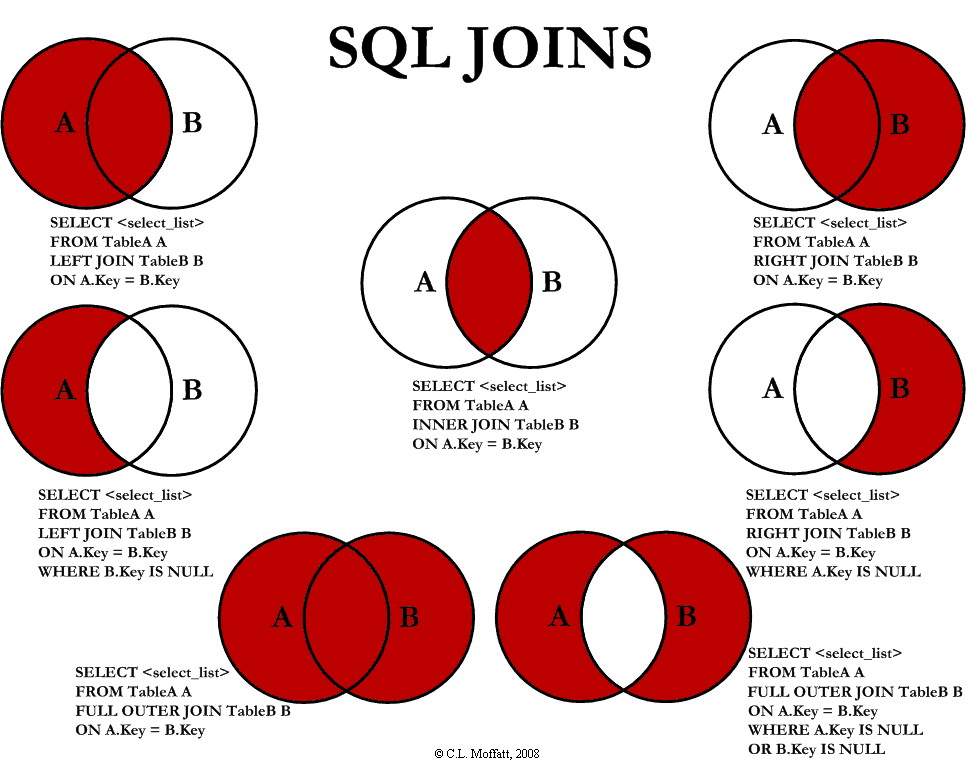

In [ ]:
sql = """
SELECT official_title
FROM public.movie INNER JOIN public.produced ON movie.id = produced.movie
WHERE country = 'IRL'
"""
pd.read_sql(sql, con=connection)

In [ ]:
# get the official_title of Irish movies 

# In SQL:
sql = """
SELECT official_title
FROM public.movie INNER JOIN public.produced ON movie.id = produced.movie
WHERE country = 'IRL'
"""
pd.read_sql(sql, con=connection)

# In Pandas

#where_condition = "country == 'IRL'"
"""pd\
    .merge(movie_df, produced_df, how='inner', left_on='id', right_on='movie')\
    .query(where_condition)["official_title"]"""

In [ ]:
# get the countries where 'Crime' movies are produced

sql = """  
SELECT DISTINCT country, genre
FROM public.genre AS genre 
inner join public.produced as country ON genre.movie = country.movie
WHERE genre = 'Crime'
"""

print(len(pd.read_sql(sql, con=connection)))



In [ ]:
print(len(pd\
    .merge(genres_df, produced_df, how="inner", on="movie")\
    .query("genre == 'Crime'")\
    ["country"].drop_duplicates()))

In [ ]:
# get the title of movies starring 'Anne Hathaway'

# In SQL:

# using multiple joins
sql = """  
SELECT official_title, year, plot
FROM imdb.person INNER JOIN imdb.crew c ON person.id = crew.movie
INNER JOIN imdb.movie ON crew.movie = movie.id
WHERE given_name = 'Anne Hathaway'
"""
pd.read_sql(sql, con=connection)

# In Pandas:
pd.merge(person_df, crew_df, how="inner", left_on="id", right_on="person")\
    .merge(movie_df, how="inner", left_on="movie", right_on="id", suffixes=["_person", "_movie"])\
    .query("given_name == 'Anne Hathaway'")["official_title"]



# using CTE
sql = """

WITH hathaway_movies AS (
    SELECT movie 
    FROM imdb.person INNER JOIN imdb.crew ON person.id = crew.person
    WHERE given_name = 'Anne Hathaway' 
    )
    
SELECT official_title
FROM imdb.movie INNER JOIN hathaway_movies ON id = movie
"""

# equivalent to CTE
movies_with_anne = pd.merge(crew_df, person_df, how='inner', left_on="person", right_on='id').query("given_name == 'Anne Hathaway'")
pd.merge(movie_df, movies_with_anne, how='inner', left_on="id", right_on='movie', suffixes=["_movie", "_person"])

In [ ]:
# get the ids of top 10 ranking Horror movies

# In SQL
sql = """  

WITH horror_movies AS (
    SELECT movie 
    FROM public.genre 
    WHERE genre = 'Horror'
)

SELECT horror_movies.movie
FROM horror_movies INNER JOIN public.rating ON horror_movies.movie = rating.movie
"""
pd.read_sql(sql, con=connection)


# In Pandas:

# 1. get the ids of horror movies
horror_movies = genres_df.query("genre == 'Horror'")["movie"]

# 2. get the scores for these movies, sort and get the top 10
top10_horrors = pd.merge(horror_movies, rating_df, how="inner", on="movie").sort_values("score", ascending=False)[:10]["movie"]
top10_horrors

In [ ]:
# get the title of movies produced in one of the following countries: 'AUS', 'GBR' or 'IRL'.

# In SQL:
sql = """ 
SELECT official_title, country
FROM imdb.movie 
INNER JOIN imdb.produced ON id = movie
WHERE country IN ('AUS', 'GBR', 'IRL')
"""
print(len(pd.read_sql(sql, con=connection)))


# In Pandas:

# 1. merge two dataframes
merged_df = pd.merge(movie_df, produced_df, how="inner", left_on="id", right_on="movie")

# 2. specify a condition on the country column
condition = merged_df["country"].isin(('AUS', 'GBR', 'IRL'))

# 3. subset the merged dataframe
merged_df[condition][["official_title", "country"]]

## <center>Set operations</center>

### INTERSECT

In [ ]:
# get movies produced in both USA and FRA

# In SQL:

# using set operation INTERSECT
sql = """
SELECT movie
from imdb.produced 
where country = 'USA'

INTERSECT

SELECT movie
from imdb.produced 
where country = 'FRA'
"""

# using self-join of the table produced
sql = """
SELECT p1.movie
FROM imdb.produced AS usa INNER JOIN imdb.produced AS fra ON usa.movie = fra.movie 
WHERE p1.country = 'USA' AND p2.country = 'FRA'
"""

# using nested query
sql = """  
SELECT movie
FROM imdb.produced
WHERE country = 'USA' AND movie IN (
    SELECT movie
    FROM imdb.produced
    WHERE country = 'FRA')
"""

# using CTE
sql = """
WITH usa_movies AS (
    SELECT movie
    FROM imdb.produced
    WHERE country = 'USA'
),
    fra_movies AS (
    SELECT movie
    FROM imdb.produced
    WHERE country = 'FRA')

SELECT usa.movie
FROM usa_movies AS usa INNER JOIN fra_movies as fra ON usa.movie = fra.movie
"""

pd.read_sql(sql, con=connection)

In pandas, there is no method implementing INTERSECT operation. Joins between tables can be exploited instead.

In [ ]:
# In Pandas:

# 1. get movies produced in USA
movies_usa = movie_df.query('country == "USA"')[["movie", "official_title"]]

# 2. get movies produced in FRA
movies_fra = movie_df.query('country == "FRA"')[["movie", "official_title"]]

# 3.merge two dataframes (equivalennt to the SQL CTE)
pd.merge(movies_usa, movies_fra, on='movie')

# 3. an alternative solution via isin(): 
movies_usa[movies_usa["movie"].isin(movies_fra["movie"])]

Also include the title! (JOIN is needed)

In [ ]:

# 1. get movies produced in USA
movies_usa = pd.merge(movie_df, produced_df, how='inner', left_on='id', right_on='movie').query('country == "USA"')[["movie", "official_title"]]

# 2. get movies produced in FRA
movies_fra = pd.merge(movie_df, produced_df, how='inner', left_on='id', right_on='movie').query('country == "FRA"')[["movie", "official_title"]]

# 3.merge two dataframes (equivalennt to the SQL CTE)
pd.merge(movies_usa, movies_fra, on='movie')

# 3. an alternative solution via isin(): 
movies_usa[movies_usa["movie"].isin(movies_fra["movie"])]

In [ ]:
# return movies starring Matthew McConaughey as BOTH actor and producer

# In SQL:

# using set operation INTERSECT
sql = """

-- get movies where Matthew McConaughey is an actor
SELECT movie
FROM imdb.crew INNER JOIN imdb.person ON crew.person = person.id
WHERE given_name = 'Matthew McConaughey' AND p_role = 'actor'

INTERSECT

-- get movies where Matthew McConaughey is a producer
SELECT movie
FROM imdb.crew INNER JOIN imdb.person ON crew.person = person.id
WHERE given_name = 'Matthew McConaughey' AND p_role = 'producer'
"""

# using nested query
sql = """  
SELECT movie
FROM imdb.crew INNER JOIN imdb.person ON crew.person = person.id
WHERE given_name = 'Matthew McConaughey' AND p_role = 'actor' AND movie IN (
    SELECT movie
    FROM imdb.crew INNER JOIN imdb.person ON crew.person = person.id
    WHERE given_name = 'Matthew McConaughey' AND p_role = 'producer'
)
"""

# using self-join of the table crew
sql = """
SELECT g1.movie
FROM imdb.crew c1 
INNER JOIN imdb.crew c2 ON c1.person = c2.person
INNER JOIN imdb.person p1 ON c1.person = p1.id
INNER JOIN imdb.person p2 ON c2.person = p2.id
WHERE p1.given_name = 'Matthew McConaughey' AND c1.p_role = 'actor'
AND p2.given_name = 'Matthew McConaughey' AND c2.p_role = 'producer' 
"""

pd.read_sql(sql, con=connection)

In [ ]:
# In Pandas:

# 1. get the ids of movies where McConaughey is an 'actor'
as_actor = pd.merge(crew_df, person_df, how='inner', left_on='person', right_on='id').query("given_name == 'Matthew McConaughey' and p_role == 'actor'")["movie"]

# 2. get the ids of movies where McConaughey is a 'producer'
as_producer = pd.merge(crew_df, person_df, how='inner', left_on='person', right_on='id').query("given_name == 'Matthew McConaughey' and p_role == 'producer'")["movie"]

# 3. Keep only the horror movies that appear among thrillers 
pd.merge(as_actor, as_producer, how="inner", on="movie")

### EXCEPT

In [ ]:
# return movies without rating

# In SQL:

# using EXCEPT operator
sql = """
SELECT id
FROM imdb.movie
EXCEPT
SELECT movie 
FROM imdb.rating
"""

# using nested query
sql = """
SELECT id
FROM imdb.movie 
WHERE id NOT IN (
    SELECT movie 
    FROM imdb.rating
    )
"""

# using LEFT JOIN
sql = """
SELECT id
FROM imdb.movie 
LEFT JOIN imdb.rating ON movie.id = rating.movie
WHERE rating.movie IS NULL;
"""

len(pd.read_sql(sql, con=connection))

In Pandas, there is no specific method for the EXCEPT operation.\
An equivalent effect can be achieved by negating the condition that uses `isin()` operator.

In [ ]:
# In Pandas:

# 1. get the ids of all movies with rating, 
# simply take the movie column from the rating table
movies_with_rating = rating_df["movie"]

# 2. for each id in the movie table, check if the movie id appears in the rating table
is_rated = movie_df["id"].isin(movies_with_rating)

# 3. use the above condition to subset the movie table, only selecting rows where the condition is True
movie_df[is_rated]

# 4. negate the condition using ~, so that 'movie id IS IN the rating table' becomes 'movie id IS NOT IN the rating table' 
movie_df[~is_rated]

In [ ]:
# return movies that are not Thriller: 
# the condition does not refer to a single row, but to a movie, which may have several rows associated
# Reasoning: you do NOT want to filter out rows that have the value 'Thriller', but rather movies that have 'Thriller' as one of their genres.
# Therefore, the condition cannot be verified at the level of a single record.
# Instead, it should be verified at the level of a block of rows referring to the same movie.
# movie can have more genres
# In SQL:

# using set operation EXCEPT
sql = """ 
-- get all movies
SELECT id
FROM imdb.movie 

EXCEPT

-- get 'Thriller' movies
SELECT movie
FROM imdb.genre
WHERE genre = 'Thriller'
"""

# using nested query
sql = """ 
-- get all movies
SELECT id
FROM imdb.movie 

-- get the complementary set of 'Thriller' movies
WHERE id NOT IN (
    -- get the ids of 'Thriller' movies
    SELECT movie 
    FROM imdb.genre
    WHERE genre = 'Thriller'
    )
"""
len(pd.read_sql(sql, con=connection))


# In Pandas:

# 1. get the ids of 'Thriller' movies
ids_of_thrillers = genres_df[genres_df["genre"] == 'Thriller']["movie"]

# 2. for each id in the movie table, check if the movie id appear among 'Thriller' ids
is_thriller = movie_df["id"].isin(ids_of_thrillers)

# 3. get the complementary set of the 'Thriller' movies, using the above condition
len(movie_df[~is_thriller])

### `UNION` & `UNION ALL` (keeps duplicates)

In pandas, use `concat()` to perform an equivalent to SQL `UNION ALL` operation. The result keeps duplicate rows. \
`concat()` in  conjunction with `drop_duplicates()` with produce an equivalent to SQL `UNION`, removing duplicate rows from the result set.

In [ ]:
# get movies produced in Australia or those never rated lower than 8.5
# movie can have multiple ratings!
# In SQL:

# using set operations
sql = """ 
-- get movies produced in Australia
SELECT movie
FROM imdb.produced 
WHERE country = 'AUS' 
UNION
(
    -- taking all rated movies
    SELECT movie
    FROM imdb.rating 

    -- excluding movies rated below 8.5
    EXCEPT 
    SELECT movie 
    FROM imdb.rating
    WHERE score <= 8.5
)
"""

# using nested query
sql = """ 
-- get movies produced in Australia
SELECT movie
FROM imdb.produced 
WHERE country = 'AUS' 
UNION 

-- get the complementary set to low-rating movies
SELECT movie
FROM imdb.rating 
WHERE movie NOT IN (

    -- get movies with low rating
    SELECT movie 
    FROM imdb.rating
    WHERE score <= 8.5
    )
"""


pd.read_sql(sql, con=connection)

# In Pandas

# 1. get movies produced in Australia
australian_movies = produced_df.query("country == 'AUS'")

# 2. get movies with low rating
low_rating_movies = rating_df[rating_df["score"]<= 8.5]["movie"]

# 3. get the complementary to low-rating movies
high_rating_movies = rating_df[~rating_df["movie"].isin(low_rating_movies)]

pd.concat([australian_movies, high_rating_movies]).drop_duplicates()

### Aggregations

Aggregation in pandas is done by computing columns based on an aggregate function: MIN, MAX, AVG, SUM, COUNT

In [ ]:
movie_df.length.min()        # MIN
movie_df.length.max()        # MAX
movie_df.length.mean()       # AVG
movie_df.length.sum()        # SUM
movie_df.length.count()      # COUNT NOT NULL
movie_df.length.nunique()    # COUNT DISTINCT

In [ ]:
# return the length of the longest movie in the database

# In SQL:
sql = """
SELECT max(length)
FROM public.movie
"""
print(pd.read_sql(sql, con=connection))

# In Pandas:
movie_df.length.max()

Aggregates are used in nested queries

In [ ]:
# return the longest movie in the database
# returning the movie with the max length is different from returning the value of the max length ! 
# you need to use nested query to obtain the correct result

# In SQL:
sql = """
SELECT *
FROM imdb.movie
WHERE length = (
    SELECT MAX(length)
    FROM imdb.movie
    )
"""
print(pd.read_sql(sql, con=connection))

# In Pandas:
max_length = movie_df["length"].max()
movie_df[movie_df["length"] == max_length]

In [ ]:
# retrieve the oldest movie

sql = """
SELECT * FROM imdb.movie 
WHERE year = (SELECT MIN(year) FROM imdb.movie)
"""
pd.read_sql(sql, con=connection)

# In Pandas:
# first cast the column 'year' to a float, otherwise you get an error when evaluating the min 
movie_df["year"] = movie_df["year"].astype(float)
movie_df[movie_df["year"] == movie_df["year"].min()]

### GROUP BY

In pandas, SQL’s GROUP BY operations are performed using the `groupby()` method.


In [ ]:
# grouping rows by a single column
produced_df.groupby("country")

# grouping by multiple columns
crew_df.groupby(["movie", "p_role"])

In [203]:
crew_df.groupby(["movie", "p_role"])


** NOTE! **

Differently from SQL, in Pandas `NA` values are excluded from group keys during the groupby operation. To include them, set `dropna` = False.

In [207]:
produced_df.groupby("country", dropna=False)


*Inspecting grouped dataframe*

In [208]:
# Use `.groups` attibute to returns a dictionary, where
# keys are the unique groups and values are the elements belonging to each group.

produced_df.groupby("country").groups

{'ARE': [96, 139], 'AUS': [74, 161], 'AUT': [56], 'BRA': [251], 'CAN': [11, 17, 69, 103, 125, 128, 194, 203], 'CHE': [248], 'CHN': [14, 57, 89, 91, 99, 124, 142, 182, 193, 219], 'COG': [63], 'DEU': [58, 85, 134, 236], 'ESP': [111, 215, 218], 'FRA': [1, 5, 192, 228, 235, 240, 243, 246, 254, 257, 267, 269, 276], 'GBR': [0, 3, 8, 10, 13, 18, 19, 22, 53, 62, 64, 84, 164, 189, 199, 201, 247, 275], 'GTM': [129], 'HKG': [54, 71, 92], 'IND': [59, 132, 135, 140, 145, 148, 153], 'IRL': [2, 258], 'ISL': [12], 'ITA': [234, 237, 238, 239, 241, 242, 244, 245, 249, 250, 253, 255, 256, 259, 260, 261, 262, 263, 264, 265, 266, 268, 270, 271, 272, 273, 274], 'JPN': [29, 100], 'NLD': [4], 'NZL': [119, 151], 'USA': [6, 7, 9, 15, 16, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 60, 61, 65, 66, 67, 68, 70, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 90, 93, 94, 95, 97, 98, 101, 102, 104, 105, 106, 107, 108, 109, 11

In [209]:
# select a group by key
produced_df.groupby("country").get_group("AUS")

,movie,country
74,1343092,AUS
161,0374463,AUS


### Grouped Aggregations


Use `.agg()` method to apply any reduction function to all columns.

In [210]:
# using .agg() method that accepts any reduction method as a string 
crew_df.groupby("movie").agg("count")

,person,p_role,character
movie,,,
0069049,22,22,11
0365907,85,85,65
0369610,215,215,208
0374463,33,33,14
0384580,4,4,0
...,...,...,...
7131622,1,1,0
7221090,12,12,10
7293754,11,11,0


*Apply multiple reduction functions to all columns*.

In [219]:
# using .agg() with a list to apply multiple reduction methods to all columns at once
crew_df.groupby("movie").agg(["size", "count", "nunique"])

person               p_role               character              
          size count nunique   size count nunique      size count nunique
movie                                                                    
0069049     22    22      21     22    22       3        22    11      10
0365907     85    85      85     85    85       2        85    65      60
0369610    215   215     213    215   215       4       215   208     120
0374463     33    33      31     33    33       4        33    14      13
0384580      4     4       3      4     4       2         4     0       0
...        ...   ...     ...    ...   ...     ...       ...   ...     ...
7131622      1     1       1      1     1       1         1     0       0
7221090     12    12      12     12    12       2        12    10      10
7293754     11    11      10     11    11       2        11     0       0
7407340      2     2       2      2     2       2         2     0       0
7428530      6     6       5      6     6       3         6     1       1

[209 rows x 9 columns]

*Apply different reduction functions to different columns*.

In [220]:
# using .agg() with a dict to apply different reduction methods to different columns
crew_df.groupby("movie").agg({"person": "nunique", "p_role": 'size'})

,person,p_role
movie,,
0069049,21,22
0365907,85,85
0369610,213,215
0374463,31,33
0384580,3,4
...,...,...
7131622,1,1
7221090,12,12
7293754,10,11


*Named aggregation with `.agg()`*

In [221]:
crew_df.groupby("movie").agg(
    unique_people = ("person", "nunique"), 
    cast_size =     ("p_role", 'size')
    )

,unique_people,cast_size
movie,,
0069049,21,22
0365907,85,85
0369610,213,215
0374463,31,33
0384580,3,4
...,...,...
7131622,1,1
7221090,12,12
7293754,10,11


In [233]:
# for each actor count the number of movies
# In SQL:

sql = """
SELECT person, count(movie) as n_movies
FROM public.crew
WHERE p_role = 'actor'
GROUP BY person
"""
pd.read_sql(sql, con=connection)

,person,n_movies
0,7300642,1
1,0701818,2
2,1940449,1
3,0263141,1
4,5014801,1
...,...,...
7685,1293441,1
7686,5651029,1
7687,4128579,1
7688,1218295,1


In [235]:
# find the actor with the highest number of movies

sql = """
-- compute the virtual table of counts for each actor
WITH count_people AS (
    SELECT person, COUNT(movie) AS n_movies
    FROM public.crew
    WHERE p_role = 'actor'
    GROUP BY person
    )
    
-- use the computed table in the nested query inside the WHERE clause to select the movie with MAX length
-- the JOIN with the 'person' table is needed if we also want to return the given_name 
SELECT given_name, n_movies
FROM count_people INNER JOIN public.person ON count_people.person = person.id
WHERE n_movies = (
    SELECT MAX(n_movies) 
    FROM count_people
    )
"""
pd.read_sql(sql, con=connection)

,given_name,n_movies
0,Leonardo DiCaprio,13


In [ ]:
# find the movie with the highest number of cast members

sql = """
-- compute the virtual table of counts for each movie
WITH count_people AS (
    SELECT movie, count(person) as n_people
    FROM imdb.crew 
    GROUP BY movie)

-- use the computed table of counts in the WHERE clause to select the movie with MAX n_people
-- the JOIN with movie is only needed if you want to also return the official_title
SELECT official_title, n_people
FROM count_people INNER JOIN imdb.movie ON count_people.movie = movie.id 
WHERE n_people = (
    SELECT MAX(n_people) 
    FROM count_people)
"""
pd.read_sql(sql, con=connection)

In [ ]:
# return the given_name of the actors with more than 50 movies

# In SQL:

# when using the HAVING clause, you can't use the alias of the new column: 'n_movies'
# because the HAVING is evaluated before the SELECT, which will be eveluated as last.
# Thus, you need to compute the aggregation over a column in the HAVING clause AS well.

sql = """
SELECT person.id, given_name, count(movie) AS n_movies
FROM imdb.person LEFT JOIN imdb.crew ON person.id = crew.person
WHERE p_role = 'actor' 
GROUP BY person.id, given_name
HAVING count(movie) > 50 
"""

print(len(pd.read_sql(sql, con=connection)))

# In Pandas:

# 1) JOIN dataframes
merged_df = pd.merge(person_df, crew_df, how='left', left_on='id', right_on='person')

# 2) Filter rows
merged_df = merged_df[(merged_df["p_role"] == 'actor') | (merged_df["p_role"].isna())]

# 3) Group by and aggregate rows
gouped_df = merged_df.groupby(["id", "given_name"], dropna=False).agg(n_movies=("movie", "count"))

# 4) Filter groups
gouped_df[gouped_df["n_movies"]> 50]

In [ ]:
# for each alive actor, count the number of movies, and return the year of her first and last movie along with her given_name

# In SQL:

sql = '''
SELECT person.id, given_name,
       count(distinct movie) AS n_movies,
       min(year) AS first,
       max(year) AS last
FROM imdb.person 
INNER JOIN imdb.crew ON id = person
LEFT JOIN imdb.movie ON crew.movie = movie.id
WHERE death_date IS NULL AND p_role = 'actor' 
GROUP BY person.id, given_name -- include 'given_name' in GROUP BY in order to then return it in the SELECT 
ORDER BY n_movies DESC
'''

print(len(pd.read_sql(sql, con=connection)))

# In Pandas:

# 1. join tables
merged_df = pd.merge(person_df, crew_df, how="inner", left_on="id", right_on="person")
merged_df = merged_df.merge(movie_df, how="left", left_on='movie', right_on='id', suffixes=["_person", "_movie"])

# 2. filter rows
is_alive = merged_df.death_date.isna()
is_actor = merged_df.p_role == 'actor'
is_null_role = merged_df.p_role.isna()

merged_df = merged_df[is_alive & (is_actor | is_null_role)]

# group and aggregate
merged_df\
    .groupby(["id_person","given_name"], dropna=False)\
    .agg({"movie":"nunique", 'year':['min', 'max']})\
    .sort_values(by=('movie', 'nunique'), ascending=False)